In [1]:
import gc, argparse, sys, os, errno
from IPython.core.display import HTML,Image
from functools import reduce
import h5py
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
output_notebook()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.neighbors import NearestNeighbors
from bokeh.palettes import Category20c
from ipywidgets import interact,interactive, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [2]:
def PCA_plot_with_uca_score_sns(ax,data,sampleclass,batchinfo,method_type, uca_score, kbet_score, method = 'PCA'):
    X = log_transform(data).T
    X = StandardScaler().fit_transform(X)
    if method == 'PCA':
        transform = PCA()
    elif method == 'tSNE':
        transform = TSNE()
    elif method == 'UMAP':
        transform = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
    
    X_pca = transform.fit_transform(X)
    plot_table = pd.DataFrame(X_pca[:,:2])
    plot_table.index = data.columns
    plot_table = pd.concat((plot_table,sampleclass.loc[plot_table.index],batchinfo.loc[plot_table.index]),axis=1)
    plot_table.columns = ['Dimension 1','Dimension 2','class','batch']
    classnum = np.unique(plot_table.iloc[:,2]).shape[0]
    sns.scatterplot(ax=ax,data=plot_table,x="Dimension 1", y="Dimension 2",
                    palette=sns.color_palette()[:classnum] , hue="batch",style='class',s=110)
    plt.figure(linewidth=30.5)
    ax.legend(bbox_to_anchor = (1, 1))
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #uca_score = get_clustering_score(data, sampleclass)
    ax.set_title(method_type + ': ' +'UCA = {:.3f}'.format(uca_score) +', ' + 'kBET = {:.3f}'.format(kbet_score))
    #ax.annotate('UCA score: {:.6f}'.format(uca_score),xy=(1,0),xycoords='data',size=6.5)
    #print('Alignment score: {}'.format(knn_score(X_pca, sampleclass.loc[data.columns.values].values.ravel() )))
    return uca_score

def log_transform(data, small = 0.01):
    return np.log2(data + small)

In [3]:
#ruv_data = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/matrix_processing/filter.null.Norm_TMM.mirna_and_domains.txt', index_col=0)
sample_class = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/sample_classes.txt', index_col=0)
batch_info = pd.read_table('/home/xieyufeng/fig3/data/cfRNA/batch_info.txt', index_col=0)

In [4]:
kbet_table = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/select_preprocess_method/kbet_score/mirna_and_domains/summary.txt', index_col = 0)
uca_table = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/select_preprocess_method/uca_score/mirna_and_domains/summary.txt', index_col = 0)

In [5]:
kbet_table

,kbet_score
preprocess_method,
filter.null.Norm_TMM.Batch_limma_1,0.9936
filter.null.Norm_RLE.Batch_ComBat_1,0.9640
filter.null.Norm_TMM.Batch_ComBat_1,0.9328
filter.null.Norm_CPM_top.Batch_ComBat_1,0.8932
filter.null.Norm_RLE.Batch_limma_1,0.8692
filter.null.Norm_CPM.Batch_limma_1,0.8192
filter.null.Norm_CPM_top.Batch_limma_1,0.7888
filter.null.Norm_CPM.Batch_null,0.7200
filter.null.Norm_RLE.Batch_RUV,0.6512


In [6]:
uca_table

,uca_score
preprocess_method,
filter.null.Norm_RLE.Batch_limma_1,0.684211
filter.null.Norm_CPM.Batch_RUV,0.624060
filter.null.Norm_CPM.Batch_ComBat_1,0.571429
filter.null.Norm_CPM_top.Batch_RUV,0.563910
filter.null.Norm_TMM.Batch_RUV,0.556391
filter.null.Norm_RLE.Batch_RUV,0.556391
filter.null.Norm_CPM.Batch_limma_1,0.556391
filter.null.Norm_TMM.Batch_null,0.526316
filter.null.Norm_CPM.Batch_null,0.526316


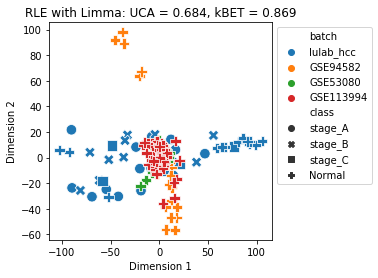

<Figure size 432x288 with 0 Axes>

In [7]:
## 手动写入表头信息，包括方法、UCA和kBET的值

## Import data 
data = pd.read_table('/home/xieyufeng/fig3/output/cfRNA/matrix_processing/filter.null.Norm_RLE.Batch_limma_1.mirna_and_domains.txt',
                          index_col = 0)

fig, ax = plt.subplots(figsize=(4,4))
ucascore = PCA_plot_with_uca_score_sns(ax,data, 
                                       sample_class, batch_info, 
                                       'RLE with Limma',   # 方法
                                       0.684211,               # UCA
                                       0.8692,                 # kBET
                                       method='PCA'
                                      )